In [1]:
import sys; sys.path.insert(0, "..")

In [2]:
from HSIC.HSIC import hsic_gam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

# Experiment 1 - Synthetic Data

### Single Example Run

In [94]:
# Generate 1000 random numbers from a normal gaussian distribution
# with mean 0 and standard deviation 1
x = np.random.normal(0, 1, 1000)
n = np.random.normal(0, 1, 1000)
b = 1
y = (np.array([x + b*x**3 + n])).T


In [95]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

### Training the forward model and plotting the results

/Users/karan/miniconda3/envs/data-science/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


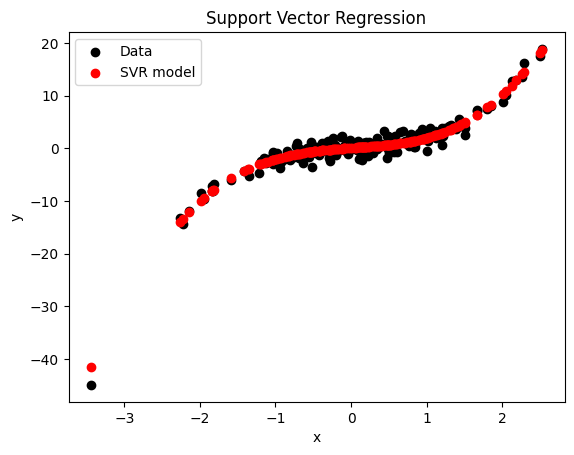

In [96]:
# Split the data into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Fit the model to the training data

svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))

# Predict the values of the test data

y_pred = svr.predict(x_test.reshape(-1,1))

# Plot the results

plt.scatter(x_test, y_test, color='black', label='Data')
plt.scatter(x_test, y_pred, color='red', label='SVR model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

#### HSIC Independence scoe of X vs n_hat

In [98]:
hsic = hsic_gam(x_test, y_pred.reshape(-1,1) - y_test)
print(hsic)

if hsic[0] < hsic[1]:
    print("The forward model is accepted")
else:
    print("The forward model is rejected")


(0.13469801043669508, 0.3051283064395289)
The forward model is accepted


#### Training the reverse model

/Users/karan/miniconda3/envs/data-science/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


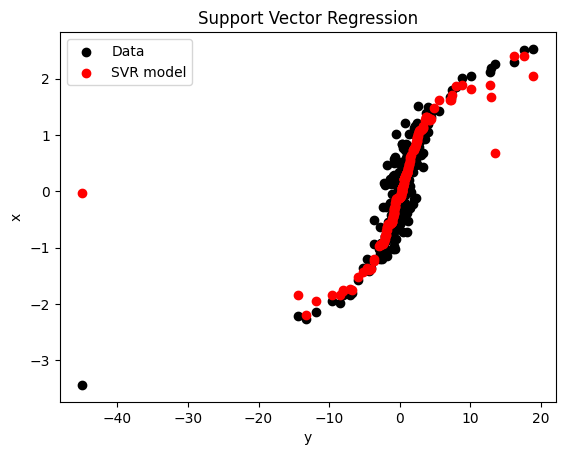

In [99]:
# Fit the model to the training data

svr_2 = SVR(kernel='rbf', C=1e2, gamma=1)
svr_2.fit(y_train.reshape(-1,1), x_train.reshape(-1,1))

# Predict the values of the test data

x_pred = svr_2.predict(y_test.reshape(-1,1))

# Plot the results

plt.scatter(y_test, x_test, color='black', label='Data')
plt.scatter(y_test, x_pred, color='red', label='SVR model')
plt.xlabel('y')
plt.ylabel('x')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In [101]:
hsic = hsic_gam(y_test, x_pred.reshape(-1,1) - x_test)
print(hsic)

if hsic[0] < hsic[1]:
    print("The reverse model is accepted")
else:
    print("The reverse model is rejected")

(1.282055656597528, 0.31529135754971005)
The reverse model is rejected


## Main Experiment

### Generating the parameters for testing and defining the model

In [106]:
# Generating two arrays of random numbers sampled
# uniformly. The first array has 50 values from 0.5 to 2 
# and the second array has 50 values from -1 to 1

q_arr = np.random.uniform(0.5, 2, 100)
b_arr = np.random.uniform(-1, 1, 100)

In [107]:
# Defining a function that accepts four arrays of numbers x_train and y_train
# # and x_test and y_test  
# and performs a SVR regression of y onto x and returns the
# predicted values of y

def svr(x_train, y_train, x_test, y_test):
    svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr.fit(x_train.reshape(-1,1), y_train.reshape(y_train.shape[0],))
    y_pred = svr.predict(x_test.reshape(-1,1))
    return y_pred

### Experiment 1: Fixed q, varying b

In [108]:
# For each value of q and b, we generate 1000 random numbers from a normal
# gaussian distribution with mean 0 and standard deviation 1. We then
# calculate the predicted values of y using the svr function and store
# the results in a list

p_matrix_correct = np.zeros((100, ))
p_matrix_rev = np.zeros((100, ))

for j in range(100):
    correct = 0
    rev = 0
    for k in range(50):
        q = 1
        b = b_arr[j]
        x = np.random.normal(0, 1, 1000)
        x = (x/np.abs(x))*(np.power(np.abs(x), q))
        n = np.random.normal(0, 1, 1000)
        n = (n/np.abs(n))*(np.power(np.abs(n), q))
        y = (np.array([x + b*x**3 + n])).T

        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


        y_pred = svr(x_train, y_train, x_test, y_test)
        x_pred = svr(y_train, x_train, y_test, x_test)

        correct_hsic = hsic_gam(x_test, y_pred.reshape(-1,1) - y_test)
        rev_hsic = hsic_gam(y_test, x_pred.reshape(-1,1) - x_test)

        if correct_hsic[0] < correct_hsic[1]:
            correct += 1
        if rev_hsic[0] < rev_hsic[1]:
            rev += 1
    p_matrix_correct[j] = correct/50
    p_matrix_rev[j] = rev/50

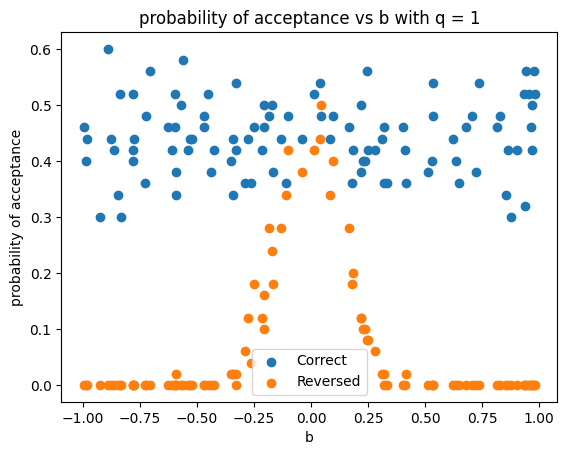

In [115]:
# Plot p_matrix_correct and p_matrix_rev against b_arr

plt.scatter(b_arr, p_matrix_correct, label='Correct')
plt.scatter(b_arr, p_matrix_rev, label='Reversed')
plt.xlabel('b')
plt.ylabel('probability of acceptance')
plt.title('probability of acceptance vs b with q = 1')
plt.legend()
plt.savefig('experiment_1.png')
plt.show()


### Experiment 2 - Fixed b, varying q

In [119]:
# For each value of q and b, we generate 1000 random numbers from a normal
# gaussian distribution with mean 0 and standard deviation 1. We then
# calculate the predicted values of y using the svr function and store
# the results in a list

p_matrix_correct_2 = np.zeros((100, ))
p_matrix_rev_2 = np.zeros((100, ))

for j in range(100):
    correct = 0
    rev = 0
    for k in range(50):
        q = q_arr[j]
        b = 0
        x = np.random.normal(0, 1, 1000)
        x = (x/np.abs(x))*(np.power(np.abs(x), q))
        n = np.random.normal(0, 1, 1000)
        n = (n/np.abs(n))*(np.power(np.abs(n), q))
        y = (np.array([x + b*x**3 + n])).T

        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


        y_pred = svr(x_train, y_train, x_test, y_test)
        x_pred = svr(y_train, x_train, y_test, x_test)

        correct_hsic = hsic_gam(x_test, y_pred.reshape(-1,1) - y_test)
        rev_hsic = hsic_gam(y_test, x_pred.reshape(-1,1) - x_test)

        if correct_hsic[0] < correct_hsic[1]:
            correct += 1
        if rev_hsic[0] < rev_hsic[1]:
            rev += 1
    p_matrix_correct_2[j] = correct/50
    p_matrix_rev_2[j] = rev/50

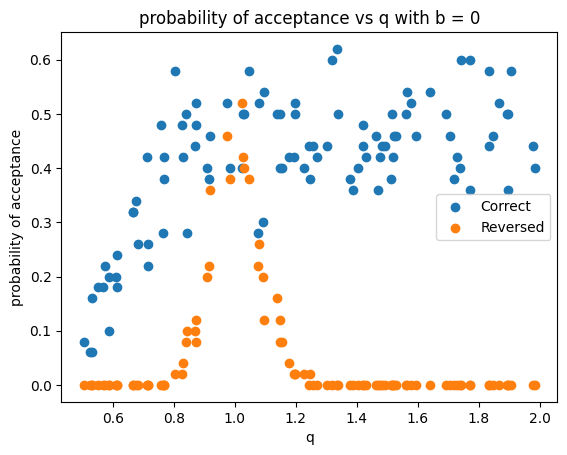

In [125]:
# Plot p_matrix_correct and p_matrix_rev against b_arr

plt.scatter(q_arr, p_matrix_correct_2, label='Correct')
plt.scatter(q_arr, p_matrix_rev_2, label='Reversed')
plt.xlabel('q')
plt.ylabel('probability of acceptance')
plt.title('probability of acceptance vs q with b = 0')
plt.legend()
plt.savefig('experiment_2.png')
plt.show()


# Abalone Dataset

In [3]:
df = pd.read_csv("Data/abalone.data", names = ["sex", "length", 'diameter', 'height', 'whole weight', 'shucked weight', 'viscera weight', 'shell weight', 'rings'])
df

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [4]:
df["age"] = df["rings"] + 1.5
df

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,8.5
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,12.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5


In [5]:
X = df["age"].values.reshape(-1,1)
y = df["length"].values.reshape(-1, 1)

### Forward Model

/Users/karan/miniconda3/envs/data-science/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


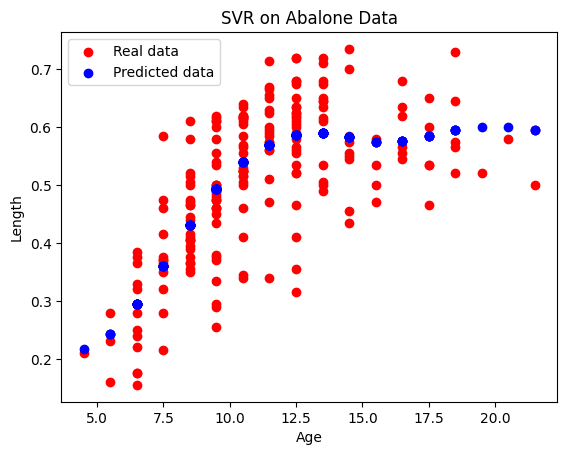

In [14]:
# Splitting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

# Fitting the SVR model to the dataset

regressor = SVR(kernel='rbf', C=1e-1, gamma=1e-1)
regressor.fit(X_train, y_train)

# Predicting a new result

y_pred = regressor.predict(X_test)

# Visualising the SVR results

plt.scatter(X_test, y_test, color='red', label = 'Real data')
plt.scatter(X_test, y_pred, color='blue', label = 'Predicted data')
plt.title('SVR on Abalone Data')
plt.xlabel('Age')
plt.ylabel('Length')
plt.legend()
plt.savefig('abalone_forward.png')
plt.show()


In [23]:
hsic = hsic_gam(X_test, y_pred.reshape(-1,1) - y_test)
print(hsic)

if hsic[0] > hsic[1]:
    print('Forward model is accepted')
else:
    print('Forward model is rejected')

(0.43841119677979884, 0.2991871607651844)
Forward model is accepted


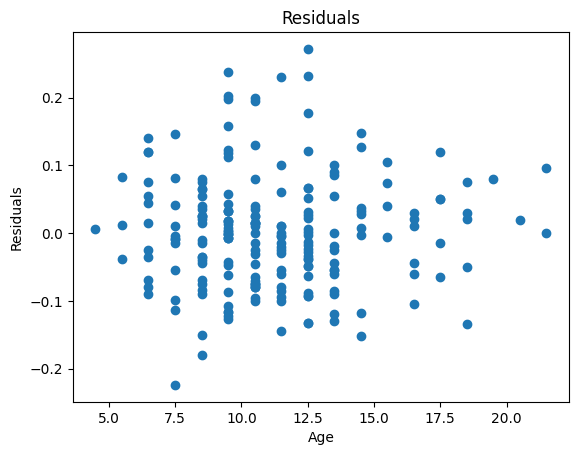

In [16]:
# Plotting the residuals

plt.scatter(X_test, y_pred.reshape(-1,1) - y_test)
plt.title('Residuals')
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.savefig('abalone_forward_residuals.png')
plt.show()


### Backward Model

/Users/karan/miniconda3/envs/data-science/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


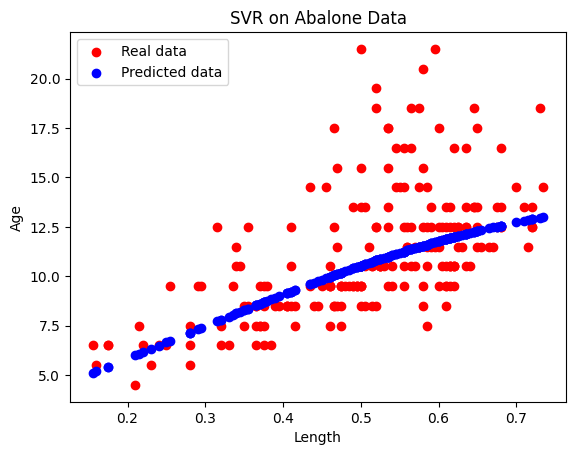

In [18]:
# Fitting the SVR model to the dataset

regressor = SVR(kernel='rbf', C=1e2, gamma=1)
regressor.fit(y_train, X_train)

# Predicting a new result

x_pred = regressor.predict(y_test)

# Visualising the SVR results

plt.scatter(y_test, X_test, color='red', label = 'Real data')
plt.scatter(y_test, x_pred, color='blue', label = 'Predicted data')
plt.title('SVR on Abalone Data')
plt.xlabel('Length')
plt.ylabel('Age')
plt.legend()
plt.savefig('abalone_reverse.png')
plt.show()


In [21]:
hsic = hsic_gam(y_test, x_pred.reshape(-1,1) - X_test)
print(hsic)

if hsic[0] < hsic[1]:
    print('Reverse model is accepted')
else:
    print('Reverse model is rejected')

(0.6896180253934907, 0.3044991421715476)
Reverse model is rejected


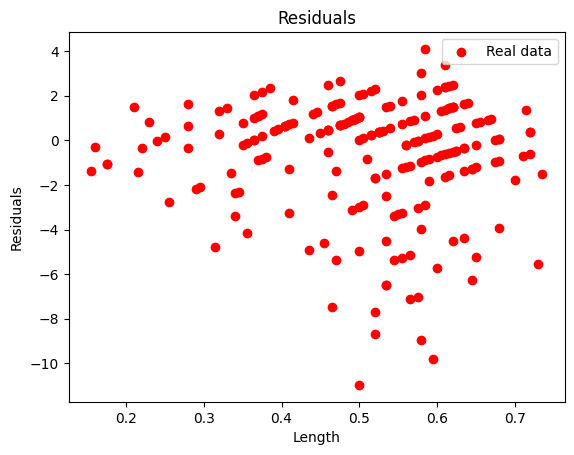

In [20]:
# Plotting the residuals

plt.scatter(y_test, x_pred.reshape(-1,1) - X_test, color='red', label = 'Real data')
plt.title('Residuals')
plt.xlabel('Length')
plt.ylabel('Residuals')
plt.legend()
plt.savefig('abalone_reverse_residuals.png')
plt.show()

